In [91]:
#main notebook
#https://blog.cambridgespark.com/getting-started-with-xgboost-3ba1488bb7d4


# Use pandas to load the data in a dataFrame
import pandas as pd
df = pd.read_excel('default_credit_card_clients/default of credit card clients.xls', header=1, index_col=0)
df.head()



,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [84]:
df.shape


(23188, 22)

As it happens sometimes with public datasets, the data is not perfectly clean and some columns have unexpected values, some customers have an education equal to 5 or 6, which does not map to anything, or a payment status equal to -2… Usually those inconsistencies should be investigated and cleaned, but since the focus of this tutorial is on xgboost, we will just remove them from our dataset

In [92]:
def clean_dataset(df):
    df.loc[~df.EDUCATION.isin([1,2,3,4]),'EDUCATION'] = pd.np.nan
    for i in [0,2,3,4,5,6]:
        df.loc[df['PAY_{}'.format(i)]< -1 ] = pd.np.nan
      
    df.dropna(inplace = True)
    return(df)
    
clean_df=clean_dataset(df)

clean_df.shape

#print(clean_df)

(23188, 24)

In [68]:
clean_df.to_csv(r'D:\Dropbox\ML\ML_flows\default_credit_card_clients\df_xgboost.csv', index = None, header=True)


Some features are categorical so we will need to create dummy variables before passing the data to xgboost. This is easily done with pandas’ get_dummies method.

In [76]:
###How get_dummies works

s = pd.Series(list('abcaa'))

s


0    a
1    b
2    c
3    a
4    a
dtype: object

In [77]:
pd.get_dummies(s) # inserting 0's

,a,b,c
0,1,0,0
1,0,1,0
2,0,0,1
3,1,0,0
4,1,0,0


In [78]:
pd.get_dummies(pd.Series(s), drop_first = True)

,b,c
0,0,0
1,1,0
2,0,1
3,0,0
4,0,0


In [93]:
def process_categorical_features(df):
    dummies_education = pd.get_dummies(df.EDUCATION,prefix='EDUCATION',drop_first=True)
    
    dummies_marriage = pd.get_dummies(df.MARRIAGE, prefix = 'MARRIAGE',
                                     drop_first=True)
    
    df.drop(['EDUCATION','MARRIAGE'],axis=1,inplace=True)
    
    return pd.concat([df, dummies_education,dummies_marriage], axis =1)



In [94]:
df = process_categorical_features(df)

df.head()

df.to_csv(r'D:\Dropbox\ML\ML_flows\default_credit_card_clients\df_xgboost2.csv', index = None, header=True)


We dropped columns EDUCATION and MARRIAGE to replace them by dummy variables, encoding each possible value. We do not need to do it for SEX as it is already a binary variable. The encoding for the payment variables (PAY_N) is not perfect either, as a positive number refers to the number of months late and -1 refers to a payment in due time. Ideally, we should process it too, but we will assume here that it means the payment was done the month before, so the continuous variable makes sense.

In [74]:
pd.Series(list('abcaa'))

0    a
1    b
2    c
3    a
4    a
dtype: object

### Prepare training and test datasets



In [95]:
y = df['default payment next month']

X = df[[col for col in df.columns if col!='default payment next month']]



In [96]:
X

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2.0,EDUCATION_3.0,EDUCATION_4.0,MARRIAGE_1.0,MARRIAGE_2.0,MARRIAGE_3.0
ID,,,,,,,,,,,,,,,,,,,,,
2,120000.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,...,1000.0,1000.0,0.0,2000.0,1,0,0,0,1,0
3,90000.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,...,1000.0,1000.0,1000.0,5000.0,1,0,0,0,1,0
4,50000.0,2.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,46990.0,...,1200.0,1100.0,1069.0,1000.0,1,0,0,1,0,0
5,50000.0,1.0,57.0,-1.0,0.0,-1.0,0.0,0.0,0.0,8617.0,...,10000.0,9000.0,689.0,679.0,1,0,0,1,0,0
6,50000.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,64400.0,...,657.0,1000.0,1000.0,800.0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000.0,1.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,188948.0,...,5003.0,3047.0,5000.0,1000.0,0,1,0,1,0,0
29997,150000.0,1.0,43.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1683.0,...,8998.0,129.0,0.0,0.0,0,1,0,0,1,0
29998,30000.0,1.0,37.0,4.0,3.0,2.0,-1.0,0.0,0.0,3565.0,...,22000.0,4200.0,2000.0,3100.0,1,0,0,0,1,0


In [97]:
y

ID
2        1.0
3        0.0
4        0.0
5        0.0
6        0.0
        ... 
29996    0.0
29997    0.0
29998    1.0
29999    1.0
30000    1.0
Name: default payment next month, Length: 23188, dtype: float64

In [98]:
#The function train_test_split from sklearn allows easy random split of a dataset.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.25, random_state = 42)

In [101]:
print(f'Size of train dataset: {X_train.shape[0]} rows')
print(f'Size of test dataset: {X_test.shape[0]} rows')


Size of train dataset: 17391 rows
Size of test dataset: 5797 rows


### Ready to train!

In [103]:
import xgboost as xgb

For this tutorial, we are going to use the sklearn API of xgboost, which is easy to use and can fit in a large machine learning pipeline using other models from the scikit-learn library
We set nthread to -1 to tell xgboost to use as many threads as available to build trees in parallel.

In [104]:
classifier = xgb.sklearn.XGBClassifier(nthread = -1, seed=42)

Let’s train a model with the default parameters. We will learn in a future tutorial how to select the best hyperparameters to improve accuracy.

In [105]:
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

### Evaluation

Let's use our trained model to predict whether the customers from the test set will default or not and evaluate the accuracy of our model.




In [107]:
predictions = classifier.predict(X_test)
predictions

array([0., 0., 1., ..., 0., 0., 0.])

Predictions are returned in a numpy array. Let’s convert it to a DataFrame for better visualisation

In [108]:
pd.DataFrame(predictions, index=X_test.index, columns = ['Predicted default']).head()

,Predicted default
ID,
5531,0.0
19730,0.0
22901,1.0
23794,0.0
17749,0.0


In [109]:
#We predict that customers #5531 will not default payment next month,whils customer #22901 will default


pd.DataFrame(y_test).head()

,default payment next month
ID,
5531,0.0
19730,0.0
22901,1.0
23794,0.0
17749,0.0


Looking at the true default outcome, it turns out our model is right for those 5 first customers!
Let’s use the score xgboost method to see how accurate our model is for all test customers:

In [110]:
print("Model Accuracy {:.2f}%".format(100*classifier.score(X_test,y_test)))

Model Accuracy 82.58%


We get a decent accuracy over 80%.


But as a good data scientist, you should take it with a pinch of salt. The problem we are working on here is unbalanced: most of the people do not default payments and the customers who default are rare in our dataset. This means that by predicting that none of the customers will default, we could get a good accuracy too, even though the model would be useless. There are ways to prevent our model to make such mistakes.

### Handy XGBOOST methods.

XGBoost comes with a set of handy methods to better understand your model



In [112]:
%matplotlib inline
import matplotlib.pyplot as plt

The plot_importance function allows to see the relative importance of all features in our model. Here we see that BILL_AMT1 and LIMIT_BAL are the most important features whilst sex and education seem to be less relevant

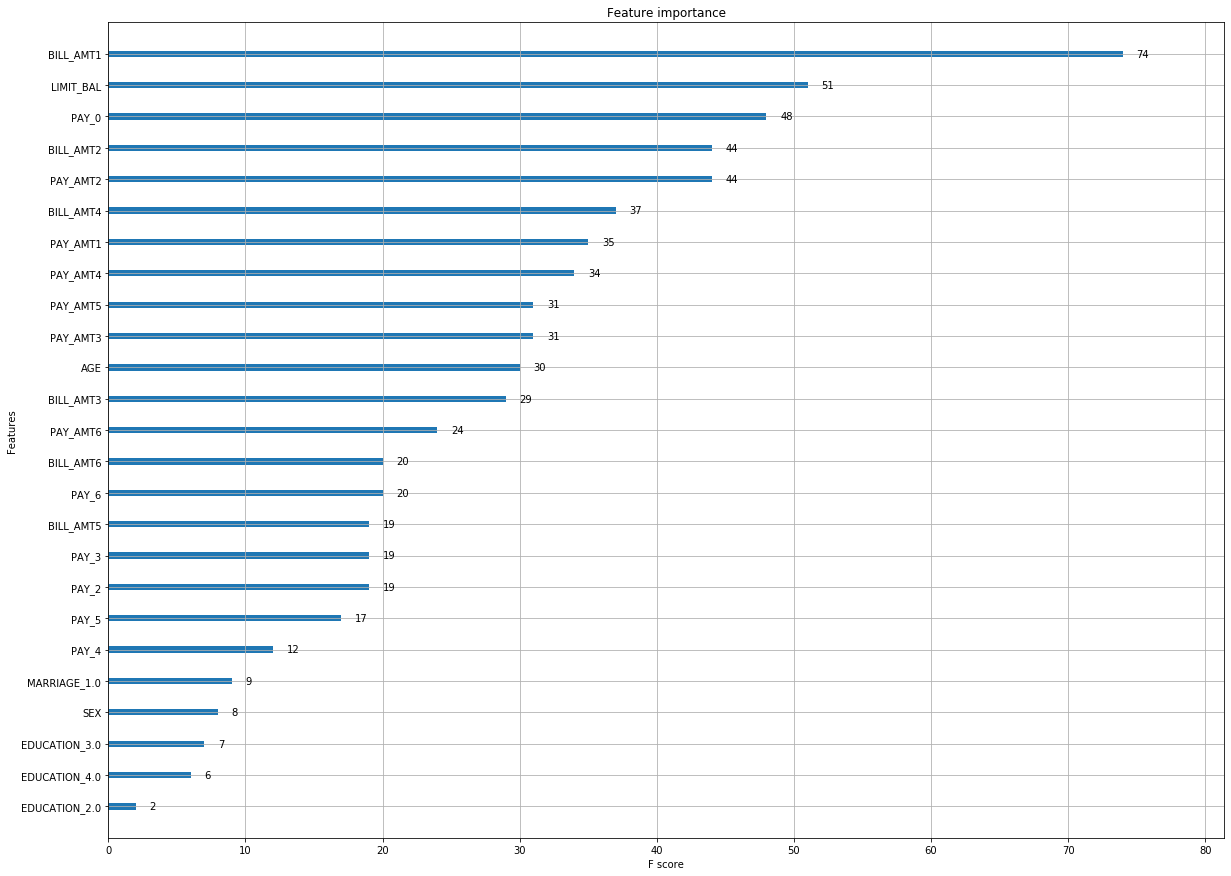

In [113]:
plt.figure(figsize = (20,15))

xgb.plot_importance(classifier, ax =plt.gca())


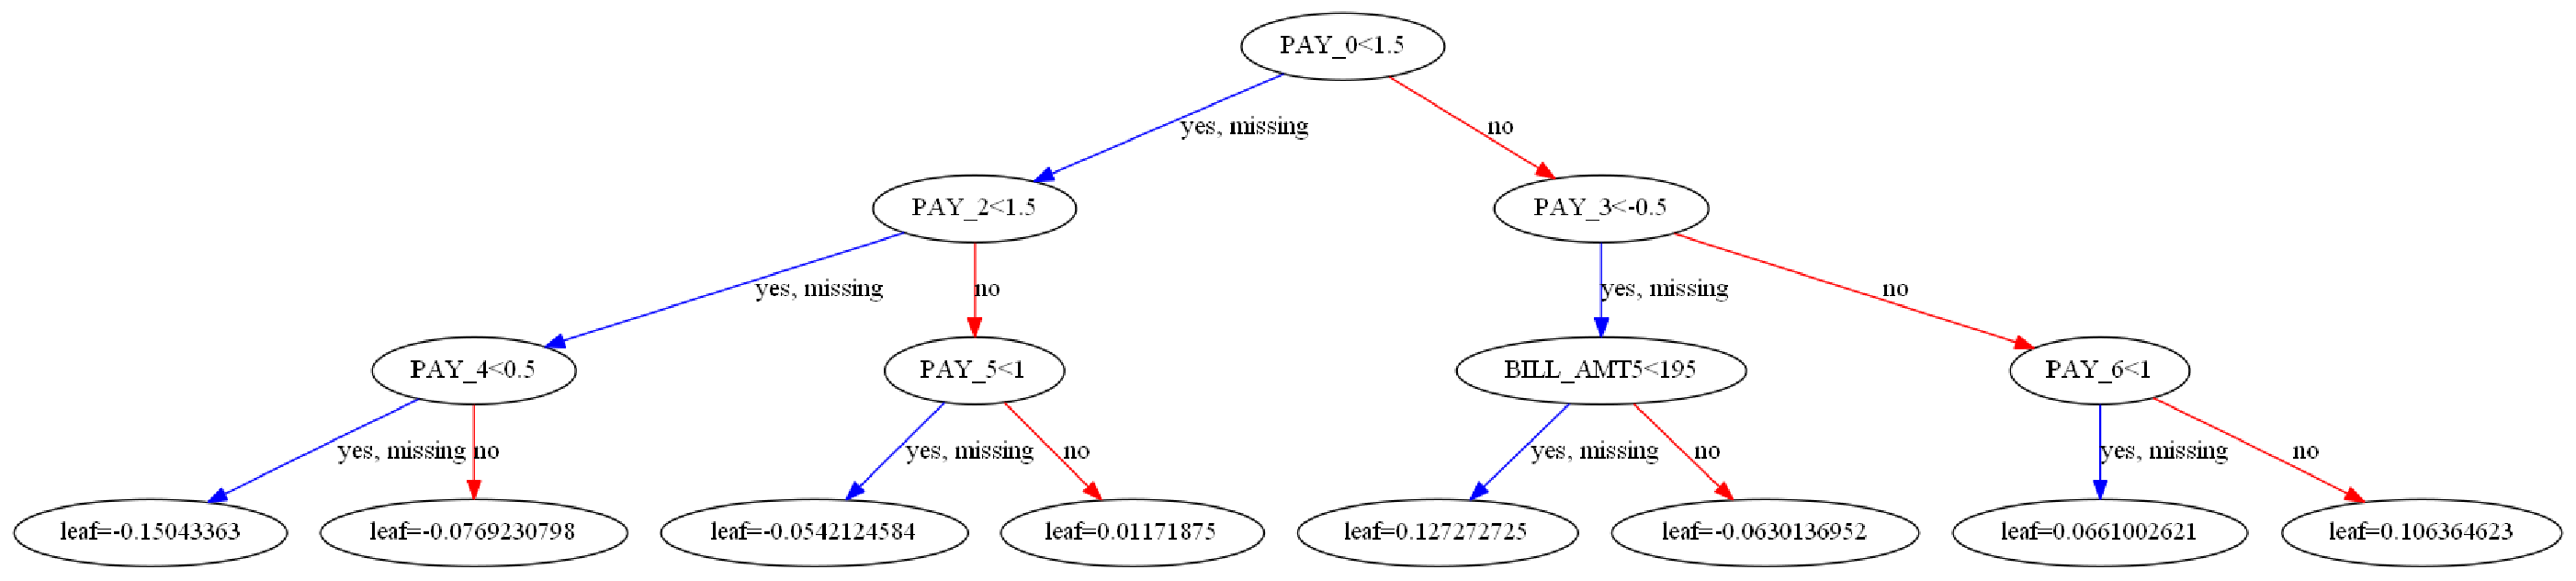

In [124]:
#plot_tree allows to visualize the trees that were built by XGBoost

import os
os.environ["PATH"] += os.pathsep + 'D:/Anaconda/Library/bin/graphviz/'


plt.figure(figsize = (50,50))

xgb.plot_tree(classifier, ax = plt.gca())

In [125]:
#We can also access the characteristics of our model

print("Number of boosting trees: {}".format(classifier.n_estimators))
print("Max depth of trees: {}".format(classifier.max_depth))
print("Objective function: {}".format(classifier.objective))

Number of boosting trees: 100
Max depth of trees: 3
Objective function: binary:logistic


As you can see, there are many parameters that define your model. Those parameters can be set before training, and selecting the good values will boost the performance of your model. We will go through ways of doing so in the next part.